<a href="https://colab.research.google.com/github/fabriziogiordano/zucchini/blob/main/Personal_Zucchini_Detectron2_Pre_Trained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

In [ ]:
# Install RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

In [ ]:
# Install dependencies
!pip install pyyaml==5.1 # torch torchvision --quiet
# workaround: install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html #--quiet
!pip install ipyplot --quiet

!gcc --version
# opencv is pre-installed on colab

#exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

In [ ]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version


In [ ]:
from PIL import Image
import numpy as np
import ipyplot

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, GenericMask, BitMasks, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
!rm -rf zucchini
!git clone --depth 1 https://github.com/fabriziogiordano/zucchini.git

In [ ]:
#Comine models and prepare it
!cat zucchini/pretrained/model.* > zucchini/pretrained/model_final.zip
!unzip zucchini/pretrained/model_final.zip -d /content > /dev/null
!rm zucchini/pretrained/model*

In [ ]:
# NEW
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR  0.00025
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = (0.7)   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
basewidth = 500
def resize(img):
  image = Image.fromarray(np.uint8(img)).convert('RGB')
  wpercent = (basewidth/float(image.size[0]))
  hsize = int((float(image.size[1])*float(wpercent)))
  image = image.resize((basewidth,hsize), Image.ANTIALIAS)
  return image
  #cv2_imshow(np.array(image))



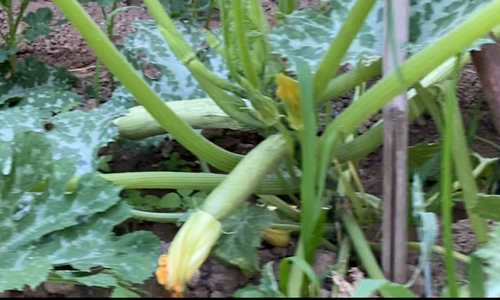
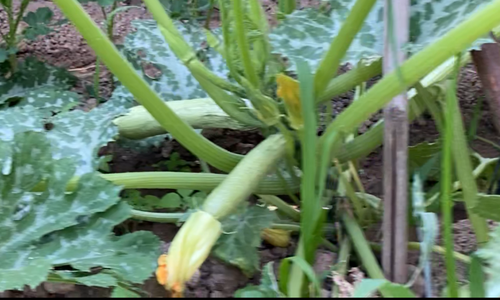


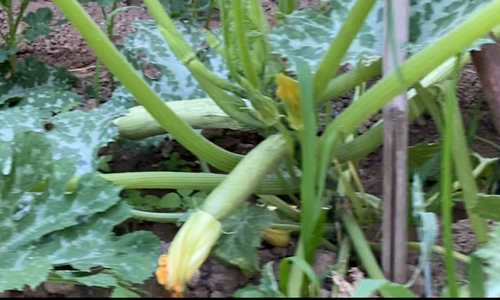
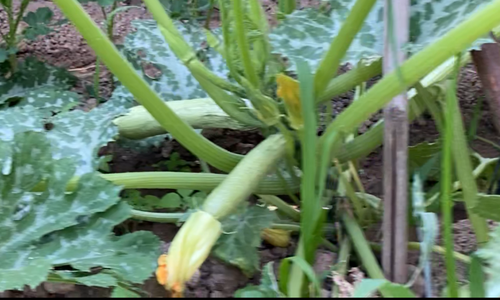

In [ ]:
#!wget "https://www.thespruce.com/thmb/T31RYYlZn20l3DfVVzacljUaofY=/960x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/companion-plants-zucchini-and-summer-squash-2540045-09-56137aa52a9445dab3fd9f6613a36ed9.jpg" -q -O input.jpg
#!wget "https://l.hdnux.com/350x235p/s3-us-west-1.amazonaws.com/contentlab.studiod/getty/b38522002081438f9be2ff162006a252.jpg" -q -O input.jpg
#!wget "https://www.piante.it/wp-content/uploads/Zucchina-pianta.jpg" -q -O input.jpg
#!wget "https://brownthumbmama.com/wp-content/uploads/2019/12/blackbeautyloadedOPT-600x600.jpg" -q -O input.jpg
#!wget "https://gardenerspath.com/wp-content/uploads/2020/05/How-to-Plant-and-Grow-Zucchini-Squash-Cover.jpg" -q -O input.jpg
#!wget "https://i.imgur.com/xrwZJph.png" -q -O input.jpg
#!wget "https://image.shutterstock.com/image-photo/close-zucchini-fruit-plants-flower-260nw-1660755553.jpg" -q -O input.jpg
#!wget "https://fscomps.fotosearch.com/bigcomps/CSP/CSP106/k33312884.jpg" -q -O input.jpg
#!wget "https://www.gardeningknowhow.com/wp-content/uploads/2016/02/zucchini-fertilizer.jpg" -q -O input.jpg
!wget "https://i.ibb.co/RyHNKq9/image.png" -q -O input.jpg
im = cv2.imread("./input.jpg")
im2 = resize(im[:, :, ::-1])

outputs = predictor(im)
# print(len(outputs["instances"]))
# print(outputs["instances"].get_fields())
v = Visualizer(im[:, :, ::-1], metadata={}, scale=1, instance_mode=ColorMode.IMAGE_BW)
img = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#cv2_imshow(img.get_image()[:, :, ::-1])

img_ai = resize(img.get_image())

ipyplot.plot_images([im2, img_ai], max_images=20, img_width=basewidth)

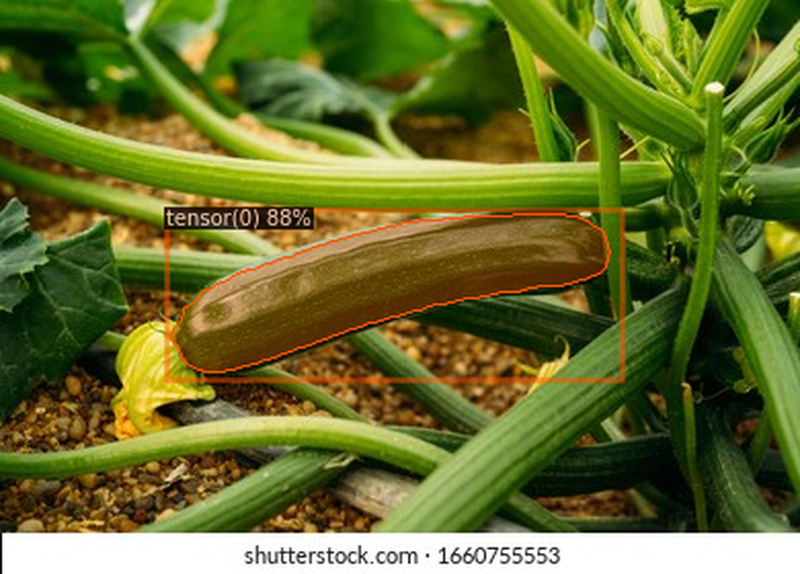

In [ ]:
results = predictor(im)

v = Visualizer(im[:, :, ::-1], metadata={}, scale=1, instance_mode=ColorMode.IMAGE_BW)
img_ai = v.draw_instance_predictions(results["instances"].to("cpu")).get_image()
#cv2_imshow(img_ai[:, :, ::-1])

PIL_image1 = Image.fromarray(np.uint8(img_ai)).convert('RGB')
basewidth = 800
wpercent = (basewidth/float(PIL_image1.size[0]))
hsize = int((float(PIL_image1.size[1])*float(wpercent)))
img = PIL_image1.resize((basewidth,hsize), Image.ANTIALIAS)
cv2_imshow(np.array(img)[:, :, ::-1])

Extracting objects...
(280, 390, 4)
[[ 81.07374 101.55135 303.25714 184.58453]]


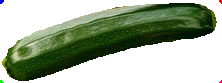

Done...


In [ ]:
background_mask_window = (0, 247, 255, 100)
background_mask_building = (255, 167, 14, 100)

# masks = (outputs["instances"].get_fields()["pred_masks"].to("cpu").numpy())
# print(masks)

background_color = (255, 255, 255, 0)

# util method to convert the detectron2 box format
def xyxy_to_xywh(box):
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])
    w = x2-x1
    h = y2-y1
    return [x1,y1,w,h]

# Cut out masks
print("Extracting objects...")
#print(results['instances'])
#print(im.shape)
index = 0
for i in range(len(results['instances'].pred_masks)):
    im = cv2.imread("./input.jpg")
    im = cv2.cvtColor(im, cv2.COLOR_RGB2RGBA)
    mask_class = results['instances'].pred_classes[i]
    #print(mask_class)
    mask = results['instances'].pred_masks[i]
    #print(mask.shape)

    x=0
    y=0
    for line in mask:
        for column in line:
            if not column:
                im[x,y] = background_color
            y+=1
        y=0
        x+=1
    # Cropping image to the size of the objects bounding box
    box = results['instances'].pred_boxes[i]
    print(im.shape)
    print(box.tensor.cpu().numpy())
    box = box.tensor.cpu().numpy()[0]
    box = xyxy_to_xywh(box)
    

    radius = 2
    thickness = 2
    
    color = (255, 0, 0, 255)
    center_coordinates = (box[0],box[1])
    im = cv2.circle(im, center_coordinates, radius, color, thickness)

    color = (0, 255, 0, 255)
    center_coordinates = (box[0],box[1]+box[3])
    im = cv2.circle(im, center_coordinates, radius, color, thickness)

    color = (0, 0, 255, 255)
    center_coordinates = (box[0]+box[2],box[1])
    im = cv2.circle(im, center_coordinates, radius, color, thickness)

    color = (100, 0, 255, 255)
    center_coordinates = (box[0]+box[2],box[1]+box[3])
    im = cv2.circle(im, center_coordinates, radius, color, thickness)


    im = im[box[1]:box[1]+box[3], box[0]:box[0]+box[2]]
    cv2_imshow(im)

print("Done...")